In [1]:
import json
import numpy as np
import pandas as pd
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from typing import Dict, List, Tuple
from collections import defaultdict
from datasets import load_dataset
from tqdm import tqdm

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

sns.set_style('whitegrid')
# Increase font sizes for readability
sns.set_context('notebook', font_scale=1.4)
plt.rcParams.update({
    'figure.figsize': (18, 8),
    'font.size': 32,
    'axes.titlesize': 28,
    'axes.labelsize': 25,
    'xtick.labelsize': 23,
    'ytick.labelsize': 23,
    'legend.fontsize': 21
})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

/home/bruno/miniconda3/envs/music-gen-interpretability/lib/python3.12/site-packages/torchmetrics/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Device: cuda


## 1. Load Custom Concept Dataset

In [2]:
# Load concept-to-tags mapping
CONCEPTS = json.load(open("../data/concepts_to_tags.json", "r"))

print("Available concept categories:")
for cat, tags in CONCEPTS.items():
    print(f"  {cat}: {len(tags)} tags (e.g., {tags[:3]})")

Available concept categories:
  tempo: 50 tags (e.g., ['medium tempo', 'slow tempo', 'fast tempo'])
  genre: 50 tags (e.g., ['rock', 'pop', 'electronic music'])
  mood: 50 tags (e.g., ['emotional', 'passionate', 'energetic'])
  instrument: 50 tags (e.g., ['acoustic drums', 'electric guitar', 'bass guitar'])


In [3]:
# Create reverse mapping
TAG_TO_CATEGORY = {}
for cat, tags in CONCEPTS.items():
    for tag in tags:
        TAG_TO_CATEGORY[tag] = cat

In [4]:
def preprocess_audio(audio_array: np.ndarray, sr: int, target_sr: int = 16000, duration: float = 3.0) -> torch.Tensor:
    """Preprocess audio to fixed length and sample rate."""
    # Resample if needed
    if sr != target_sr:
        audio_array = librosa.resample(audio_array, orig_sr=sr, target_sr=target_sr)
    
    # Trim or pad to fixed duration
    target_length = int(target_sr * duration)
    if len(audio_array) > target_length:
        audio_array = audio_array[:target_length]
    else:
        audio_array = np.pad(audio_array, (0, target_length - len(audio_array)))
    
    return torch.from_numpy(audio_array).float()

In [5]:
# Load GTZAN dataset from local folder
print("Loading GTZAN dataset from local files...")
GTZAN_PATH = Path("/media/bruno/B438-3BD6/datasets/GTZAN/Data/genres_original")

# Map genre names
GENRE_MAP = {
    'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
    'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9
}
TARGET_GENRES = list(GENRE_MAP.keys())

# Load all audio files
print("Scanning audio files...")
audio_files = []
for genre in TARGET_GENRES:
    genre_path = GTZAN_PATH / genre
    wav_files = sorted(genre_path.glob("*.wav"))
    for wav_file in wav_files:
        audio_files.append({
            'path': wav_file,
            'genre': genre,
            'label': GENRE_MAP[genre]
        })

print(f"Loaded {len(audio_files)} audio files")
print(f"Genres: {TARGET_GENRES}")
print(f"Files per genre: ~{len(audio_files) // len(TARGET_GENRES)}")

Loading GTZAN dataset from local files...
Scanning audio files...
Loaded 1000 audio files
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Files per genre: ~100


In [6]:
# Load and preprocess all GTZAN audio
print("Loading and preprocessing GTZAN audio files...")
X_train, y_train = [], []

for file_info in tqdm(audio_files, desc="Loading audio"):
    # Load audio using librosa
    try:
        audio, sr = librosa.load(file_info['path'], sr=None, mono=True)
    except Exception as e:
        print(f"Error loading {file_info['path']}: {e}")
        continue
    
    # Preprocess audio
    audio_tensor = preprocess_audio(audio, sr)
    X_train.append(audio_tensor)
    y_train.append(file_info['label'])

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)

print(f"Training data shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")
print(f"Sample rate: 16000 Hz, Duration: 3.0 seconds")

Loading and preprocessing GTZAN audio files...


Loading audio:  55%|█████▍    | 548/1000 [00:09<00:06, 73.13it/s]/tmp/ipykernel_15671/3400546144.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_info['path'], sr=None, mono=True)
/home/bruno/miniconda3/envs/music-gen-interpretability/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Loading audio:  56%|█████▋    | 564/1000 [00:09<00:05, 74.23it/s]

Error loading /media/bruno/B438-3BD6/datasets/GTZAN/Data/genres_original/jazz/jazz.00054.wav: 


Loading audio: 100%|██████████| 1000/1000 [00:15<00:00, 66.16it/s]


Training data shape: torch.Size([999, 48000])
Labels shape: torch.Size([999])
Sample rate: 16000 Hz, Duration: 3.0 seconds


## 2. Load GTZAN Dataset and Train Classifier

In [7]:
class MusicGenreClassifier(pl.LightningModule):
    """Simple CNN-based music genre classifier."""
    
    def __init__(self, num_genres: int = 10, lr: float = 0.001):
        super().__init__()
        self.save_hyperparameters()
        
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=400, hop_length=160, n_mels=64
        )
        
        # CNN feature extractor
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Bottleneck layer (for TCAV)
        self.bottleneck = torch.nn.Linear(128, 256)
        self.classifier = torch.nn.Linear(256, num_genres)
        self.relu = torch.nn.ReLU()
        self.criterion = torch.nn.CrossEntropyLoss()
    
    def forward(self, x: torch.Tensor, return_bottleneck: bool = True):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        
        # Convert to mel-spectrogram
        if x.shape[1] == 1 and x.shape[2] > 1000:
            x = self.mel_spectrogram(x)
            x = torchaudio.transforms.AmplitudeToDB()(x)
        
        x = self.features(x)
        x = x.view(x.size(0), -1)
        
        bottleneck = self.bottleneck(x)
        x = self.relu(bottleneck)
        logits = self.classifier(x)
        
        if return_bottleneck:
            return logits, bottleneck
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x, return_bottleneck=False)
        loss = self.criterion(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x, return_bottleneck=False)
        loss = self.criterion(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

# Initialize model
model = MusicGenreClassifier(num_genres=len(TARGET_GENRES), lr=0.0005)
print(f"Model params: {sum(p.numel() for p in model.parameters()):,}")

Model params: 128,714


In [8]:
TRAIN_MODEL = False
MODEL_CHECKPOINT_PATH = Path("../models/best-genre-classifier.ckpt")

# Create checkpoint directory if it doesn't exist
MODEL_CHECKPOINT_PATH.parent.mkdir(parents=True, exist_ok=True)

print(f"Training mode: {'ENABLED' if TRAIN_MODEL else 'DISABLED'}")
print(f"Model checkpoint path: {MODEL_CHECKPOINT_PATH}")

Training mode: DISABLED
Model checkpoint path: ../models/best-genre-classifier.ckpt


In [9]:
# Train or load the classifier
if TRAIN_MODEL:
    print("Training genre classifier on GTZAN...")
    
    # Split data
    indices = torch.randperm(len(X_train))
    train_size = int(0.8 * len(X_train))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    X_train_split = X_train[train_indices]
    y_train_split = y_train[train_indices]
    X_val = X_train[val_indices]
    y_val = y_train[val_indices]
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_split, y_train_split)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=16, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=16, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    # Setup trainer with checkpoint callback
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath=MODEL_CHECKPOINT_PATH.parent,
        filename='genre_classifier_best',
        monitor='val_acc',
        mode='max',
        save_top_k=1,
        save_last=True
    )
    
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator='auto',
        devices=1,
        callbacks=[
            checkpoint_callback,
            pl.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                mode='min'
            )
        ],
    )
    
    # Train
    trainer.fit(model, train_loader, val_loader)
    
    # Save the best model
    print(f"✓ Model training complete!")
    print(f"✓ Best model saved to: {checkpoint_callback.best_model_path}")
    
    # Load best model
    model = MusicGenreClassifier.load_from_checkpoint(
        checkpoint_callback.best_model_path,
        num_genres=len(TARGET_GENRES)
    )
    
else:
    print("Loading pre-trained model from checkpoint...")
    
    if MODEL_CHECKPOINT_PATH.exists():
        model = MusicGenreClassifier.load_from_checkpoint(
            MODEL_CHECKPOINT_PATH,
            num_genres=len(TARGET_GENRES)
        )
        print(f"✓ Model loaded from: {MODEL_CHECKPOINT_PATH}")
    else:
        print(f"⚠ Checkpoint not found at {MODEL_CHECKPOINT_PATH}")
        print("Please set TRAIN_MODEL=True to train a new model first.")
        raise FileNotFoundError(f"Model checkpoint not found: {MODEL_CHECKPOINT_PATH}")

# Move model to device and set to eval mode
model = model.to(device)
model.eval()

print(f"Model ready on {device}")

Loading pre-trained model from checkpoint...
✓ Model loaded from: ../models/best-genre-classifier.ckpt
Model ready on cuda


## 3. Load Real Audio from Dataset

In [10]:
# Load generated audio dataset from local files
print("Loading generated audio dataset from local files...")

# Load metadata from per_sample_scores.csv
AUDIO_DATA_PATH = Path("/media/bruno/B438-3BD6/datasets/20260120/2026-01-20_17-17-18-497705")
metadata_df = pd.read_csv(AUDIO_DATA_PATH / "metadata.csv")

# Parse aspect_list column (it's stored as string representation of list)
import ast
metadata_df['aspect_list_parsed'] = metadata_df['aspect_list'].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else []
)

print(f"Loaded {len(metadata_df)} audio samples")
print(f"Audio files location: {AUDIO_DATA_PATH / 'audio_samples'}")
print(f"\nSample aspects: {metadata_df['aspect_list_parsed'].iloc[0][:5]}...")

def get_audio_by_tags(tag: str, num_samples: int) -> List[torch.Tensor]:
    """Load real audio samples that match given tags."""
    samples = []
    
    # Filter by aspect list
    matching_indices = []
    for idx, row in metadata_df.iterrows():
        aspect_list = row['aspect_list_parsed']
        if tag in aspect_list:
            matching_indices.append(idx)
            if len(matching_indices) >= num_samples:
                break
    
    loaded_count = 0
    # Load audio files
    for idx in matching_indices:
        filename = metadata_df.iloc[idx]['filename']
        audio_path = AUDIO_DATA_PATH / 'audio_samples' / filename
        
        if audio_path.exists():
            try:
                audio, sr = librosa.load(audio_path, sr=None, mono=True)
                audio_tensor = preprocess_audio(audio, sr)
                samples.append(audio_tensor)
                loaded_count += 1
                if loaded_count >= num_samples:
                    break
            except Exception as e:
                print(f"Error loading {audio_path}: {e}")
    
    if num_samples > len(samples):
        print(f"Skipping concept {tag}: Found {len(samples)}/{num_samples} samples.")
        return None
    
    return samples[:num_samples]


def create_concept_dataset_from_audio(concept: str, num_samples: int = 20) -> torch.Tensor:
    """Create dataset from real audio matching concept tags."""
    samples = get_audio_by_tags(concept, num_samples)
    if samples is None:
        return None
    return torch.stack(samples)


def create_random_audio_dataset(num_samples: int = 30) -> torch.Tensor:
    """Create random audio samples from dataset."""
    samples = []
    indices = np.random.choice(len(metadata_df), min(num_samples, len(metadata_df)), replace=False)
    
    for idx in indices:
        filename = metadata_df.iloc[idx]['filename']
        audio_path = AUDIO_DATA_PATH / 'audio_samples' / filename
        
        if audio_path.exists():
            audio, sr = librosa.load(audio_path, sr=None, mono=True)
            audio_tensor = preprocess_audio(audio, sr)
            samples.append(audio_tensor)
    
    return torch.stack(samples)

print("Audio loading functions defined.")

Loading generated audio dataset from local files...
Loaded 5358 audio samples
Audio files location: /media/bruno/B438-3BD6/datasets/20260120/2026-01-20_17-17-18-497705/audio_samples

Sample aspects: ['ambient noises', 'ambient sounds', 'digital drums', 'electronic music', 'emotional']...
Audio loading functions defined.


## 4. TCAV Implementation

In [11]:
class TCAV:
    """Testing with Concept Activation Vectors - Improved Implementation."""
    
    def __init__(self, model: torch.nn.Module, device: torch.device):
        self.model = model.to(device)
        self.device = device
    
    def get_activations(self, audio: torch.Tensor, batch_size: int = 32) -> np.ndarray:
        """Extract bottleneck activations in batches."""
        activations = []
        
        # Process in batches to avoid memory issues
        for i in range(0, len(audio), batch_size):
            batch = audio[i:i+batch_size].to(self.device)
            with torch.no_grad():
                _, bottleneck = self.model(batch)
            activations.append(bottleneck.cpu().numpy())
        
        return np.vstack(activations)
    
    def get_directional_derivatives(self, audio: torch.Tensor, cav: np.ndarray, 
                                   target_class: int, batch_size: int = 32) -> np.ndarray:
        """Compute directional derivatives along CAV direction."""
        audio = audio.to(self.device)
        cav_tensor = torch.from_numpy(cav).float().to(self.device)
        
        derivatives = []
        
        for i in range(0, len(audio), batch_size):
            batch = audio[i:i+batch_size]
            batch.requires_grad = True
            
            # Forward pass through bottleneck
            logits, bottleneck = self.model(batch)
            
            # Get gradient of target class logit w.r.t. bottleneck
            target_logits = logits[:, target_class]
            
            # Compute gradients
            grads = torch.autograd.grad(
                outputs=target_logits.sum(),
                inputs=bottleneck,
                create_graph=False
            )[0]
            
            # Directional derivative: gradient dot CAV
            directional_deriv = torch.matmul(grads, cav_tensor)
            derivatives.append(directional_deriv.detach().cpu().numpy())
        
        return np.concatenate(derivatives)
    
    def train_cav(self, concept_acts: np.ndarray, random_acts: np.ndarray, 
                  num_runs: int = 10, test_size: float = 0.2) -> Dict:
        """Train CAV using SVM with improved preprocessing and validation."""
        
        cavs, scores = [], []
        
        for run in range(num_runs):
            # Combine data
            X = np.vstack([concept_acts, random_acts])
            y = np.hstack([
                np.ones(len(concept_acts)), 
                np.zeros(len(random_acts))
            ])
            
            # Split with stratification
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=run, stratify=y
            )
            
            # Robust standardization (handles outliers better)
            from sklearn.preprocessing import RobustScaler
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Add L2 normalization for better SVM performance
            from sklearn.preprocessing import normalize
            X_train_normalized = normalize(X_train_scaled, norm='l2')
            X_test_normalized = normalize(X_test_scaled, norm='l2')
            
            # Train linear SVM with class weight balancing
            clf = SVC(
                kernel='linear', 
                C=0.1,  # Lower C for better generalization
                class_weight='balanced',  # Handle any class imbalance
                random_state=run
            )
            clf.fit(X_train_normalized, y_train)
            
            # Extract and normalize CAV
            cav = clf.coef_[0]
            cav = cav / (np.linalg.norm(cav) + 1e-8)
            
            # Evaluate
            y_pred = clf.predict(X_test_normalized)
            acc = accuracy_score(y_test, y_pred)
            
            # Only accept CAVs with reasonable performance
            if acc > 0.60:  # Better than random + margin
                cavs.append(cav)
                scores.append(acc)
        
        # If no good CAVs found, return failure
        if len(cavs) == 0:
            print(f"Warning: No CAVs with accuracy > 0.55 found")
            return {
                'cav': None,
                'accuracy': 0,
                'accuracy_std': 0,
                'num_successful_runs': 0
            }
        
        # Average CAVs and renormalize
        avg_cav = np.mean(cavs, axis=0)
        avg_cav = avg_cav / (np.linalg.norm(avg_cav) + 1e-8)
        
        return {
            'cav': avg_cav,
            'accuracy': np.mean(scores),
            'accuracy_std': np.std(scores),
            'num_successful_runs': len(scores)
        }
    
    def compute_tcav_score(self, activations: np.ndarray, cav: np.ndarray, 
                          method: str = 'directional') -> float:
        """
        Compute TCAV score.
        
        Args:
            activations: Bottleneck activations
            cav: Concept activation vector
            method: 'directional' (dot product) or 'cosine' (cosine similarity)
        """
        if method == 'cosine':
            # Normalize activations
            from sklearn.preprocessing import normalize
            acts_normalized = normalize(activations, norm='l2')
            cav_normalized = cav / (np.linalg.norm(cav) + 1e-8)
            
            # Cosine similarity
            similarities = np.dot(acts_normalized, cav_normalized)
            return np.mean(similarities > 0.1)  # Threshold for positive alignment
        
        else:  # directional (default)
            # Standard directional derivative approximation
            sensitivities = np.dot(activations, cav)
            return np.mean(sensitivities > 0)

tcav = TCAV(model, device)
print("TCAV analyzer initialized with improved implementation.")

TCAV analyzer initialized with improved implementation.


## 5. Run TCAV Analysis

In [12]:
# Analyze what aspects are actually present in the dataset
all_aspects = set()
for aspects in metadata_df['aspect_list_parsed']:
    all_aspects.update(aspects)

print(f"Total unique aspects in dataset: {len(all_aspects)}")
print(f"Sample aspects: {sorted(list(all_aspects))[:20]}")

# Define concepts to analyze based on what's in the dataset
ANALYSIS_CONCEPTS = {
    'tempo': CONCEPTS.get('tempo'),
    'instrument': CONCEPTS.get('instrument'),
}

RESULTS_PATH = Path("../data/tcav_genre_classification_results.json")

Total unique aspects in dataset: 195
Sample aspects: ['4 on the floor kick pattern', 'acoustic drums', 'acoustic guitar', 'acoustic rhythm guitar chords', 'afrobeat', 'afrobeats', 'aggressive', 'alternative rock', 'ambient', 'ambient noises', 'ambient sounds', 'ballad', 'bass', 'bass guitar', 'beat boxing', 'beatbox', 'beatboxing', 'blues', 'calm', 'calming']


In [13]:
# Generate random counterexamples from real audio
num_samples = 50
random_data = create_random_audio_dataset(num_samples=100)
random_acts = tcav.get_activations(random_data)

# Run TCAV analysis
results = defaultdict(dict)

print("\n" + "="*60)
print("TCAV ANALYSIS RESULTS")
print("="*60)

for category, concept_list in ANALYSIS_CONCEPTS.items():
    print(f"\n📊 Category: {category.upper()}")
    print("-" * 40)
    
    for concept in concept_list[:10]: # Limit to first 10 concepts for brevity
        # Load real audio for concept
        print(f"  Loading audio for '{concept}'...")
        concept_data = create_concept_dataset_from_audio(concept, num_samples=num_samples)

        if concept_data is None:
            print(f"  Skipping concept '{concept}' due to insufficient samples.")
            continue

        concept_acts = tcav.get_activations(concept_data)
        
        # Train CAV
        cav_result = tcav.train_cav(concept_acts, random_acts, num_runs=40)

        if cav_result['cav'] is None:
            print(f"  Skipping concept '{concept}' due to low CAV accuracy ({cav_result['accuracy']:.3f}).")
            continue
        
        # Compute TCAV scores for each genre using GTZAN samples
        genre_scores = {}
        for genre_name in TARGET_GENRES:
            # Get GTZAN samples for this genre
            genre_idx = GENRE_MAP[genre_name]
            genre_mask = y_train == genre_idx
            genre_samples = X_train[genre_mask]
            
            genre_acts = tcav.get_activations(genre_samples)
            genre_scores[genre_name] = tcav.compute_tcav_score(genre_acts, cav_result['cav'], method='cosine')
        
        results[category][concept] = {
            'cav_accuracy': cav_result['accuracy'],
            'genre_scores': genre_scores
        }
        
        print(f"  {concept}: CAV acc={cav_result['accuracy']:.3f}")

with open(RESULTS_PATH, "w") as f:
    json.dump(results, f, indent=4)
print(f"\n✓ TCAV results saved to: {RESULTS_PATH}")

print("\n" + "="*60)
print("✓ Analysis complete")


TCAV ANALYSIS RESULTS

📊 Category: TEMPO
----------------------------------------
  Loading audio for 'medium tempo'...
  medium tempo: CAV acc=0.633
  Loading audio for 'slow tempo'...
  slow tempo: CAV acc=0.702
  Loading audio for 'fast tempo'...
  fast tempo: CAV acc=0.633
  Loading audio for 'groovy'...
  groovy: CAV acc=0.660
  Loading audio for 'uptempo'...
  uptempo: CAV acc=0.661
  Loading audio for 'moderate tempo'...
  moderate tempo: CAV acc=0.650
  Loading audio for 'upbeat'...
  upbeat: CAV acc=0.674
  Loading audio for 'medium to uptempo'...
  medium to uptempo: CAV acc=0.700
  Loading audio for 'medium fast tempo'...
  medium fast tempo: CAV acc=0.656
  Loading audio for 'groovy rhythm'...
  groovy rhythm: CAV acc=0.647

📊 Category: INSTRUMENT
----------------------------------------
  Loading audio for 'acoustic drums'...
  acoustic drums: CAV acc=0.733
  Loading audio for 'electric guitar'...
  electric guitar: CAV acc=0.644
  Loading audio for 'bass guitar'...
  bas

## 6. Visualize Results

In [14]:
with open(RESULTS_PATH, "r") as f:
    results = json.load(f)

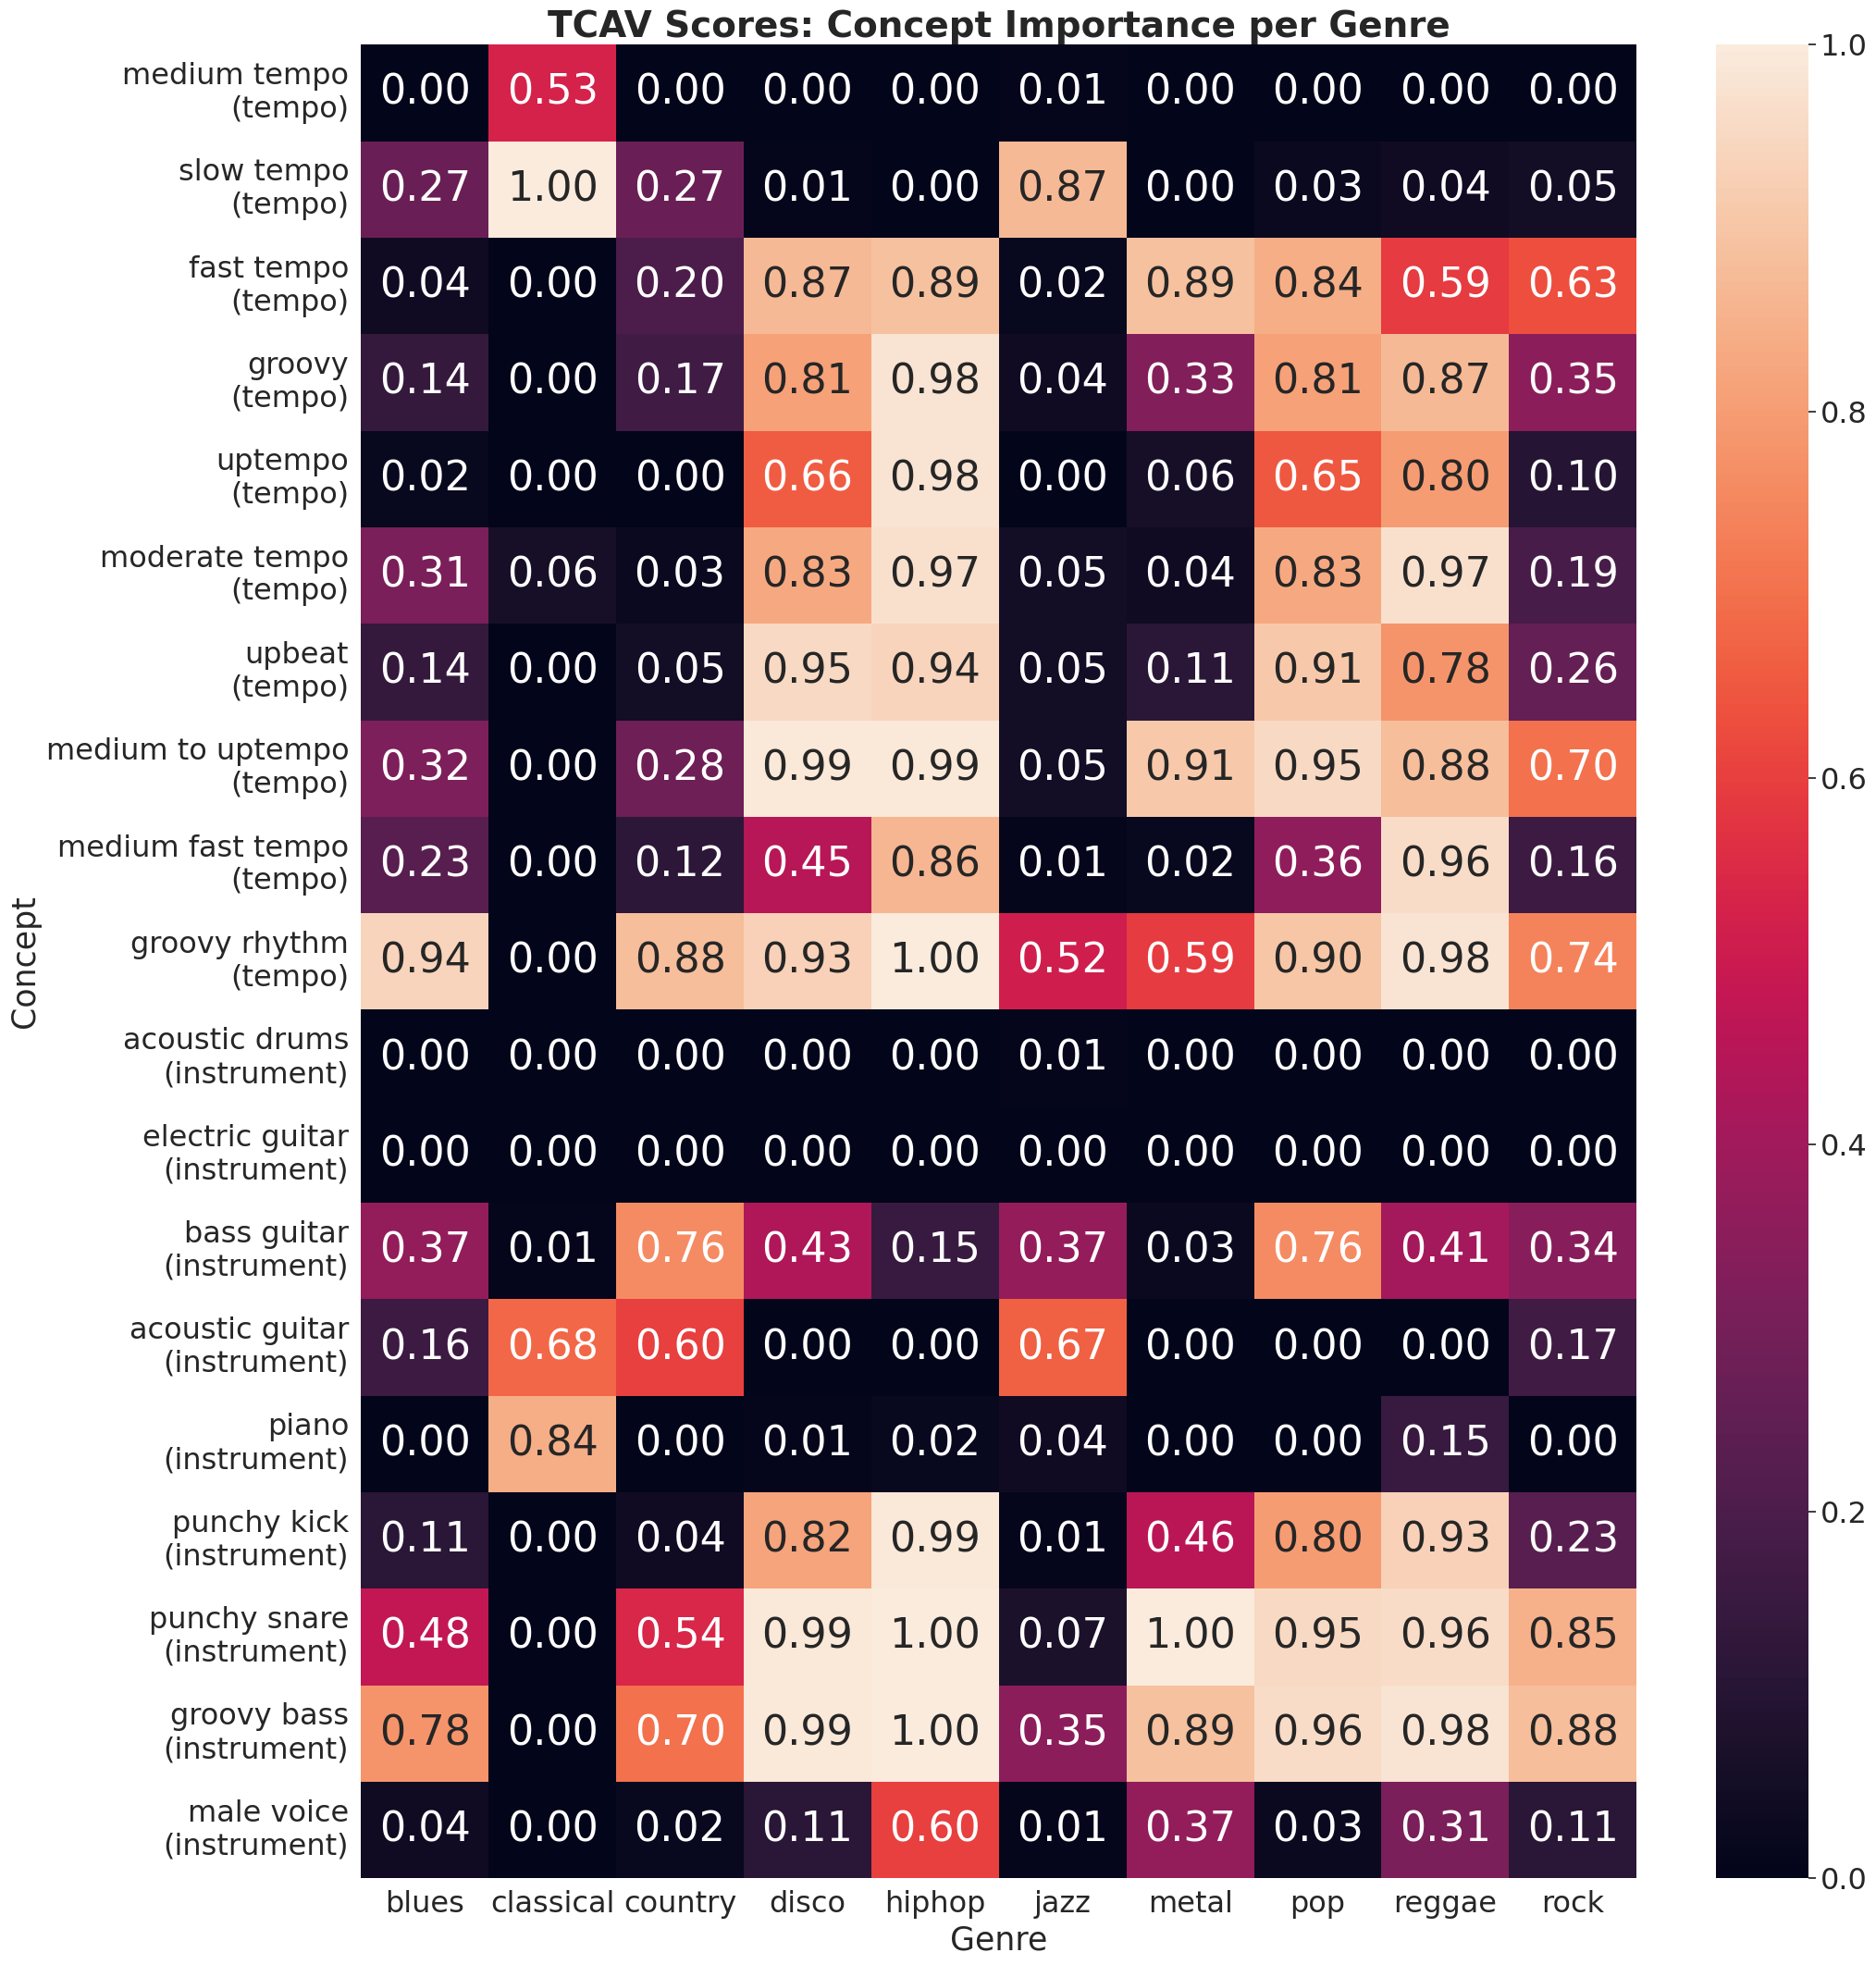

In [15]:
# Create TCAV scores heatmap
all_concepts = [c for concepts in ANALYSIS_CONCEPTS.values() for c in concepts]

# Build score matrix
score_matrix = []
concept_names = []

for category, concept_dict in results.items():
    for concept, data in concept_dict.items():
        scores = [data['genre_scores'].get(g, 0.0) for g in TARGET_GENRES]
        score_matrix.append(scores)
        concept_names.append(f"{concept}\n({category})")

score_matrix = np.array(score_matrix)

# Plot heatmap
fig, ax = plt.subplots(figsize=(22, 22))
sns.heatmap(
    score_matrix, 
    xticklabels=TARGET_GENRES,
    yticklabels=concept_names,
    annot=True, 
    fmt='.2f',
    vmin=0, vmax=1,
    ax=ax,
)
ax.set_title('TCAV Scores: Concept Importance per Genre', fontweight='bold')
ax.set_xlabel('Genre')
ax.set_ylabel('Concept')
plt.tight_layout()
plt.show()

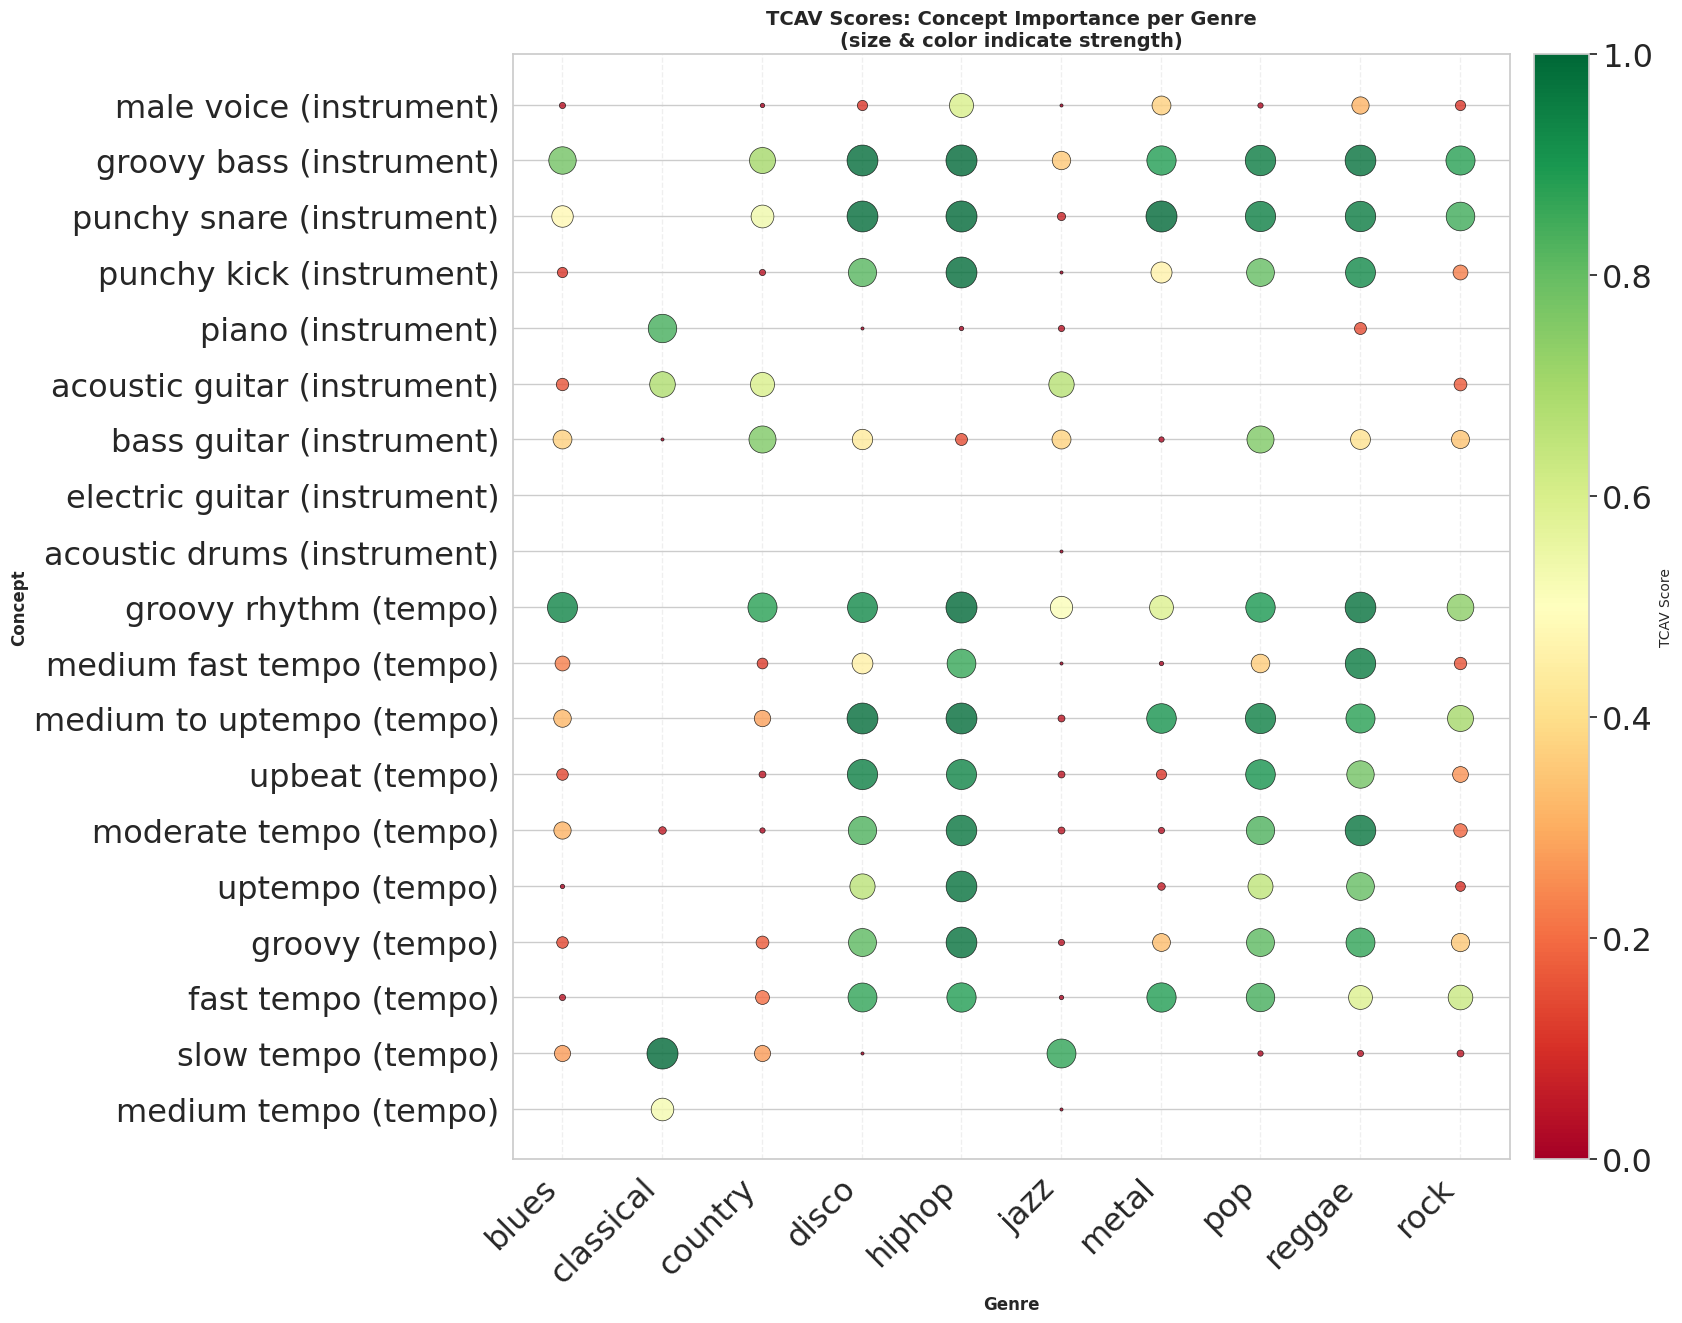

In [16]:
fig, ax = plt.subplots(figsize=(18, 14))

concept_names = []
y_positions = []
y_pos = 0

for category, concept_dict in results.items():
    for concept, data in concept_dict.items():
        for i, (genre, score) in enumerate(data['genre_scores'].items()):
            # Size and color based on score
            size = score * 500  # Scale for visibility
            color = plt.cm.RdYlGn(score)  # Red to Green colormap
            
            ax.scatter(i, y_pos, s=size, c=[color], alpha=0.8, edgecolors='black', linewidth=0.5)
        
        concept_names.append(f"{concept} ({category})")
        y_positions.append(y_pos)
        y_pos += 1

ax.set_xticks(range(len(TARGET_GENRES)))
ax.set_xticklabels(TARGET_GENRES, rotation=45, ha='right')
ax.set_yticks(y_positions)
ax.set_yticklabels(concept_names)
ax.set_xlabel('Genre', fontsize=12, fontweight='bold')
ax.set_ylabel('Concept', fontsize=12, fontweight='bold')
ax.set_title('TCAV Scores: Concept Importance per Genre\n(size & color indicate strength)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_xlim(-0.5, len(TARGET_GENRES)-0.5)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('TCAV Score', fontsize=10)

plt.tight_layout()
plt.show()

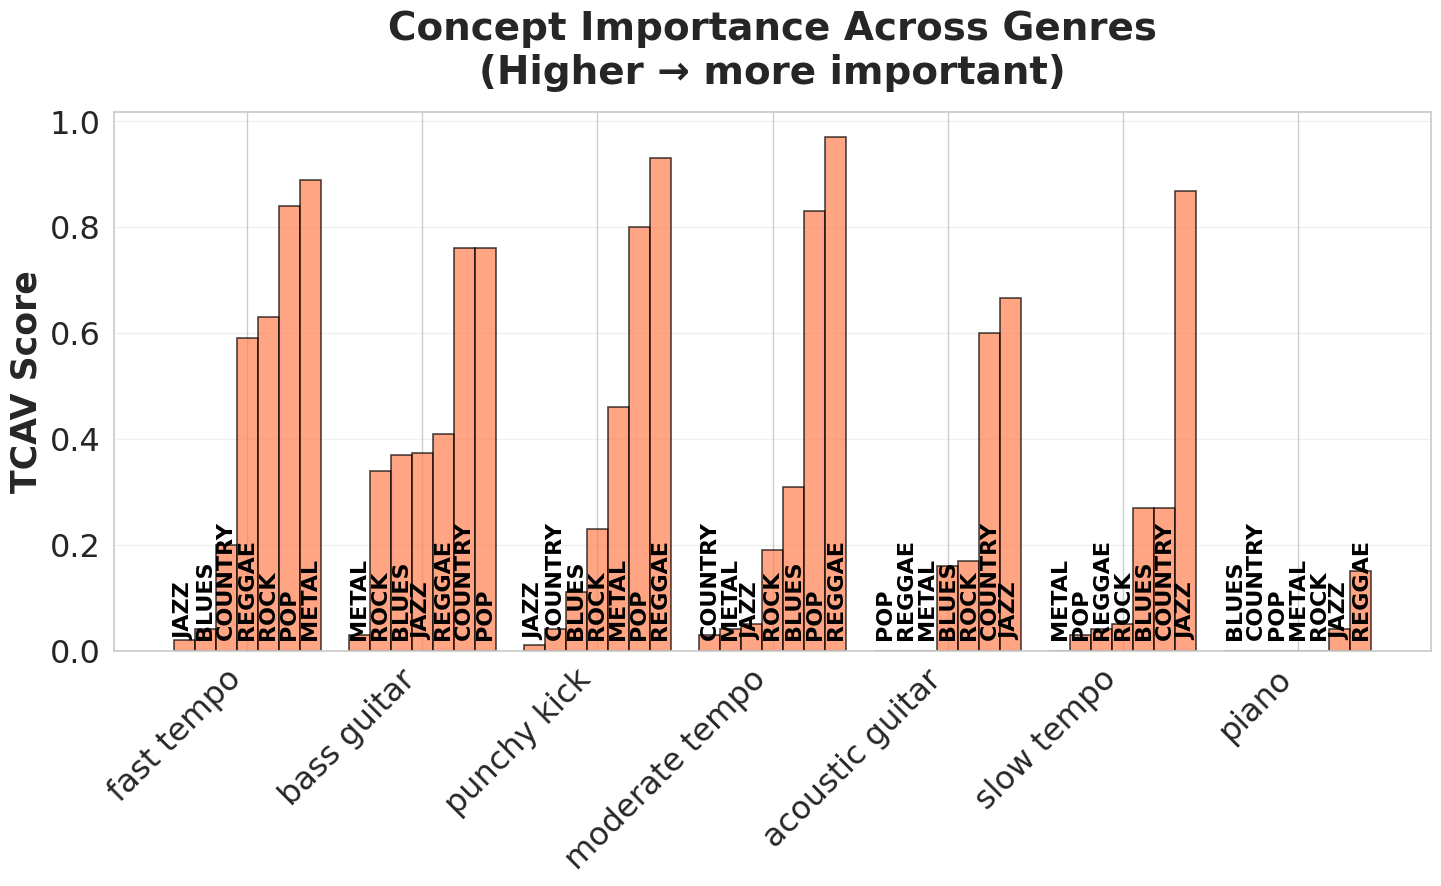

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

PLOT_GENRES = ['blues', 'country', 'jazz', 'pop', 'reggae', 'metal', 'rock']

PLOT_CONCEPTS = {
    'tempo': ['slow tempo', 'moderate tempo', 'fast tempo'],
    'instrument': ['bass guitar', 'piano', 'acoustic guitar', 'punchy kick']
}

concept_labels = []
all_scores_by_concept = []
all_categories = []

for category, concept_dict in results.items():
    if category not in PLOT_CONCEPTS:
        continue
    
    for concept, data in concept_dict.items():
        if concept not in PLOT_CONCEPTS[category]:
            continue
        
        concept_labels.append(concept)
        all_categories.append(category)
        scores = [data['genre_scores'].get(g, 0.0) for g in PLOT_GENRES]
        all_scores_by_concept.append(scores)

mean_scores = [np.mean(scores) for scores in all_scores_by_concept]
sorted_indices = np.argsort(mean_scores)[::-1]  # Sort descending

concept_labels_sorted = [concept_labels[i] for i in sorted_indices]
all_categories_sorted = [all_categories[i] for i in sorted_indices]
all_scores_sorted = [all_scores_by_concept[i] for i in sorted_indices]

fig, ax = plt.subplots(figsize=(17, 7))
x = np.arange(len(concept_labels_sorted))
width = 0.12

for concept_idx in range(len(concept_labels_sorted)):
    concept_scores = all_scores_sorted[concept_idx]
    
    genre_score_pairs = [(PLOT_GENRES[i], concept_scores[i], i) for i in range(len(PLOT_GENRES))]
    genre_score_pairs.sort(key=lambda x: x[1])
    
    for bar_idx, (genre_name, score, original_idx) in enumerate(genre_score_pairs):
        num_genres = len(PLOT_GENRES)
        position = x[concept_idx] + (bar_idx - num_genres/2) * width + width/2
        
        bar = ax.bar(position, score, width, 
                    color='coral', edgecolor='black', 
                    linewidth=1.2, alpha=0.7)
        
        ax.text(position, 0.02, genre_name.upper(), 
               rotation=90, ha='center', va='bottom', 
               fontsize=16, fontweight='bold',
               color='black')

ax.set_xlabel('', fontweight='bold')
ax.set_ylabel('TCAV Score', fontweight='bold')
ax.set_title('Concept Importance Across Genres\n(Higher → more important)', 
             fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([c for c in concept_labels_sorted], 
                   rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.savefig("../docs/assets/concept_importance_across_genres.pdf", bbox_inches='tight')
plt.show()

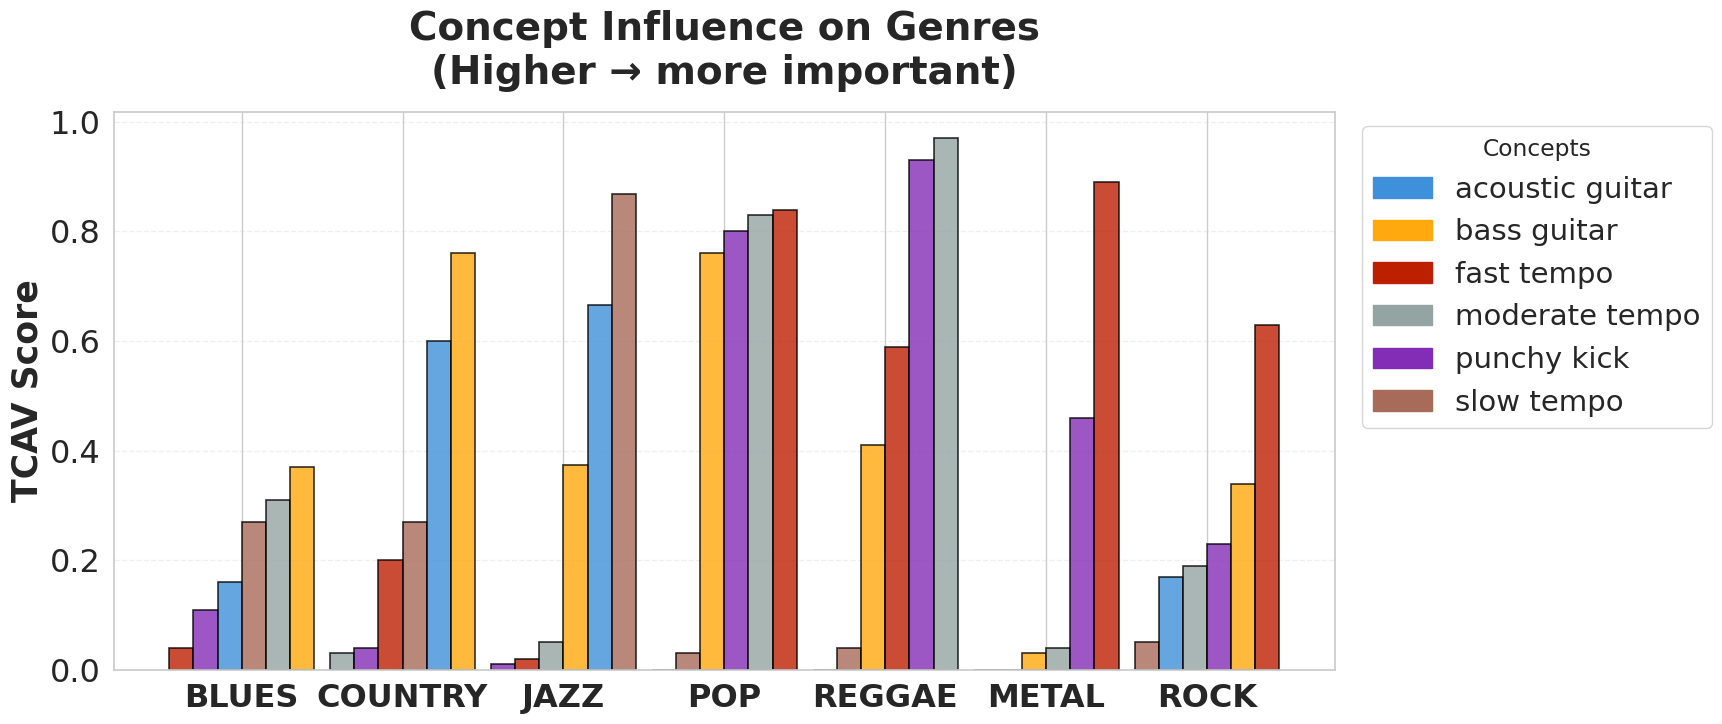

In [45]:
# ...existing code...
import matplotlib.patches as mpatches

PLOT_GENRES = ['blues', 'country', 'jazz', 'pop', 'reggae', 'metal', 'rock']

PLOT_CONCEPTS = {
    'tempo': ['slow tempo', 'moderate tempo', 'fast tempo'],
    'instrument': ['bass guitar', 'acoustic guitar', 'punchy kick']
}

all_plot_concepts = [c for cat_list in PLOT_CONCEPTS.values() for c in cat_list]
unique_concepts = sorted(list(set(all_plot_concepts)))
petroff_colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
color_map = {concept: color for concept, color in zip(unique_concepts, petroff_colors)}

fig, ax = plt.subplots()
bar_width = 0.15
x_indices = np.arange(len(PLOT_GENRES))

# 3. Plotting Loop
for i, genre in enumerate(PLOT_GENRES):
    # Collect scores for this specific genre
    genre_data = []
    
    for category, concept_dict in results.items():
        if category not in PLOT_CONCEPTS: continue
        for concept, data in concept_dict.items():
            if concept not in PLOT_CONCEPTS[category]: continue
            
            score = data['genre_scores'].get(genre, 0.0)
            genre_data.append((concept, score))
    
    genre_data.sort(key=lambda x: x[1])
    n_bars = len(genre_data)
    total_group_width = n_bars * bar_width
    start_x = i - (total_group_width / 2) + (bar_width / 2)
    
    for j, (concept, score) in enumerate(genre_data):
        pos = start_x + (j * bar_width)
        ax.bar(pos, score, width=bar_width, edgecolor='black', linewidth=1.2, color=color_map[concept], alpha=0.8)

ax.set_xticks(x_indices)
ax.set_xticklabels([g.upper() for g in PLOT_GENRES], fontweight='bold')
ax.set_ylabel('TCAV Score', fontweight='bold')
ax.set_title('Concept Influence on Genres\n(Higher → more important)', fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

legend_patches = [mpatches.Patch(color=color_map[c], label=c) for c in unique_concepts]
ax.legend(handles=legend_patches, 
          title='Concepts', 
          bbox_to_anchor=(1.01, 1), 
          loc='upper left',
          frameon=True)

plt.tight_layout()
plt.savefig("../docs/assets/concept_influence_across_genres.pdf", bbox_inches='tight')
plt.show()

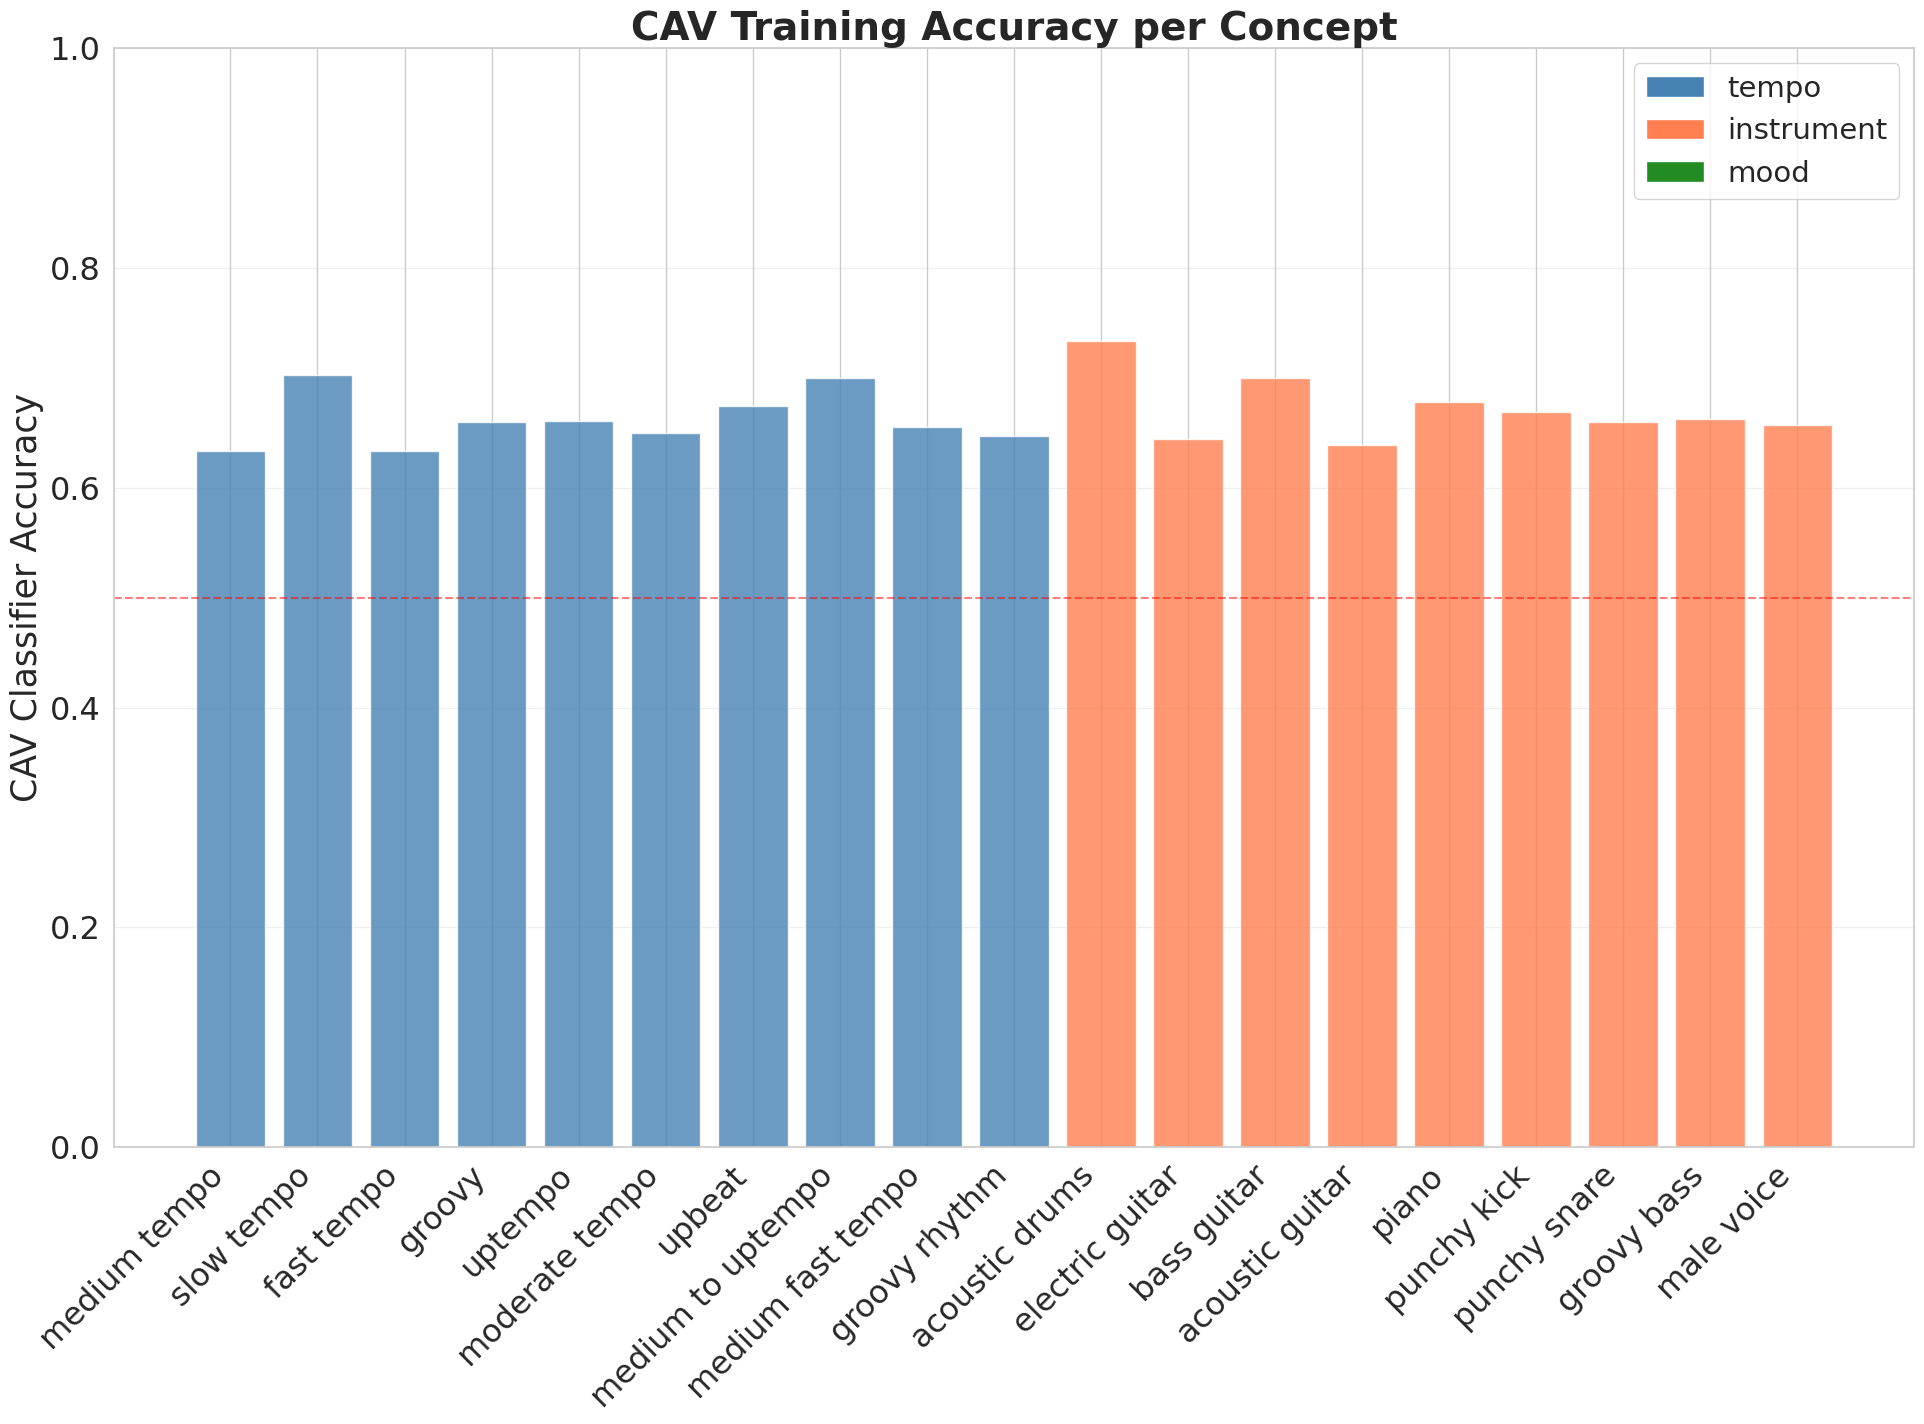

In [20]:
# Plot CAV classifier accuracies
fig, ax = plt.subplots(figsize=(20, 15))

accuracies = []
labels = []
colors = []
color_map = {'tempo': 'steelblue', 'instrument': 'coral', 'mood': 'forestgreen'}

for category, concept_dict in results.items():
    for concept, data in concept_dict.items():
        accuracies.append(data['cav_accuracy'])
        labels.append(concept)
        colors.append(color_map.get(category, 'gray'))

bars = ax.bar(range(len(accuracies)), accuracies, color=colors, alpha=0.8)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('CAV Classifier Accuracy')
ax.set_title('CAV Training Accuracy per Concept', fontweight='bold')
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random baseline')
ax.set_ylim([0, 1])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add legend for categories
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=cat) for cat, c in color_map.items()]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()